# Bag of visual words

Bag of Visual Words considers the problem of finding images of photos. Typically, we aim at finding images within a database that are similar to a given query image.

One way to compare images is pixel-by-pixel. A pixel-by-pixel comparison has the disadvantage that certain types of changes such as those caused by a change in the viewpoint cannot be handled well. Furthermore, a large number of comparisons need to be executed as each pixel of the images must be compared.

To not compare images pixel by pixel, we can use so-called "visual words" to describe images. The concept has its origins in the text retrieval community and thus the terms word and document are often used. The Bag of Visual Words concept assumes that an image can be described by a set of visual words, i.e., visual features such as SIFT descriptors. A visual word is often a "generalized" feature descriptor, most frequently it is a mean value of a cluster of similar visual features. We furthermore restrict the set of visual words that we will consider in the comparison to a dictionary. 

So, we can describe an image as a set of visual words and then aggregate the occurrences of these words in a histogram per image. By comparing these image histograms instead of the original images, we can figure out which images are visually similar. In the Bag of Visual Words notation, these are images with a small histogram difference.

There is, however, a problem with this basic approach. It occurs when the visual words occur in a lot or every image of the image database. From the histogram perspective, it is impossible to distinguish which images are similar and which are not as the histograms are not very expressive. To address this problem, we can apply the so-called TF-IDF (Term Frequency - Inverse Document Frequency) reweighting approach. It computes a weight for every bin of a histogram and will downweight the "uninformative" words (i.e., features that occur in a lot of images/everywhere) and enhance the importance of rare words.

In this notebook, we are going to look at the example of how the TF-IDF reweighting works.


## TF-IDF weighting
Let's assume we already have a bag of visual words for our images and we have 4 images that are represented through image histograms. In the example below, image 0 and image 3 are similar to each other. Thus, we expect the matching algorithm to report them as similar. The weight for every word in every histogram can be computed using the TF-IDF formula given by
$$
t_i = \frac{n_{id}}{n_d}\log \frac{N}{n_i}
$$
where 
* $n_{id}$ - occurance of word $i$ in a document (image) $d$;
* $n_d$ total number of words in a document $d$;
* $n_i$ number of documents (images in the database) that contain the word $i$
* $N$ number of documents (images in the database)

![](data/bag_of_words/histograms.png)

In the example above, image 0 contains 5 blue, 2 pink, 1 green, and no yellow or orange words. The image has in total 8 word occurances. With this information, we can compute the TF $\frac{n_{id}}{n_d}=\frac{5}{8}$.  We can observe that yellow word occurs in all 4 images, whereas, for example, the blue word occurs only in once. Thus, we can compute the overall weighting $t_i$ for all words in every histogram. We can illustrate that by:

![](data/bag_of_words/ti_calculations.png)


After reweighting the histograms, we can notice that the words that occur a lot and everywhere (blue word) gets zero weight everywhere. Interestingly, if a word occurs only once per image but in every image (green) it also get zero weights. The pink words also get more prominent in the histograms. Also just by visual inspection, it is visible more that the histograms for image 0 and image 3 are more similar after reweighting then before.

![](data/bag_of_words/histogram_comparisons.png)




To be definitely confident that reweighting helps, let's look at the cost matrix. The cost matrxix is the matrix of all possible histograms comparisons (every image compared against every image). The cost matrix shownon the left is obtained by comparing the histograms with Euclidean distance bin by bin. The cost matrix on the right depicts  the cost matrix computed using the inverse cosine distance for comparing histograms. Since image 0 and image 3 are similar, we expect the entries `cost_matrix[0][3]` and `cost_matrix[3][0]` to be similar to `cost_matrix[0][0]` and `cost_matrix[3][3]`. And indeed, for the reweighted hostograms, this is the case. 
Note, diagonal elements of the matrices result in a distance of 0 because we are comparing identical images.
![](data/bag_of_words/cost_matrices.png)

In [1]:
import numpy as np
N = 4
histograms = np.array([ [5,2,1,0,0],
                       [4,0,1,1,0],
                       [3,1,1,0,2],
                       [1,2,1,0,0]])
# Histrogram[0,:] - gets histogram for image 0

In [2]:
import matplotlib.pyplot as plt


def compute_cost_matrices(histograms):
    
    cost_matrix_eucl  = np.zeros((N,N))
    cost_matrix_cos  = np.zeros((N,N))

    for row, hist_row in enumerate(histograms):
        for col, hist_col in enumerate(histograms):
            eucl_dist = np.linalg.norm(hist_row-hist_col)
            cost_matrix_eucl[row, col] = eucl_dist
            cos_sim = np.dot(hist_row, hist_col) / (np.linalg.norm(hist_row)* np.linalg.norm(hist_col))
            cost_matrix_cos[row, col] = 1-cos_sim
    return cost_matrix_eucl, cost_matrix_cos

cm_eucl, cm_cos = compute_cost_matrices(histograms)

In [3]:
weighted_hist = np.array([ [0,0.07,0,0,0],
                           [0,0,0,0.23,0],
                           [0,0.04,0,0,2.4],
                           [0,0.14,0,0,0]])
# Histrogram[0,:] - gets histogram for image 0

Text(0.5, 1.0, 'Inv cosine')

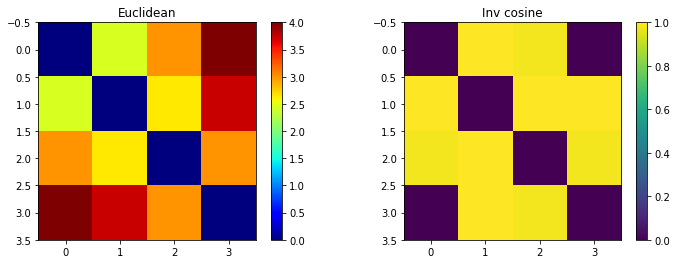

In [4]:
cm_eucl, cm_cos = compute_cost_matrices(histograms)
cm_eucl_w, cm_cos_w = compute_cost_matrices(weighted_hist)


fig, ax = plt.subplots(1,2, figsize=(12,4));

axh0 = ax[0].imshow(cm_eucl, cmap='jet') 
plt.colorbar(axh0, ax = ax[0])
ax[0].set_title("Euclidean")

axh1 = ax[1].imshow(cm_cos_w, cmap='viridis') 
plt.colorbar(axh1, ax = ax[1])
ax[1].set_title("Inv cosine")


It seems that reweighted histograms finds similar images outside the diagonal elements whereas original histograms struggle to do so.